# TCR:pMHC Structures

The following notebook summarises the structural data available for the Unravelling T Cell Recognition: Insights from Immunology and AI Hackathon.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from Bio.SeqUtils import IUPACData
from scipy import stats

In [2]:
structures_summary = pd.read_csv("data/interim/structures/structures_summary.csv")

In [3]:
print("There are", len(structures_summary), "structures in the dataset.")

There are 207 structures in the dataset.


In [4]:
structures_summary["species"] = (
    structures_summary[["alpha_chain_species", "beta_chain_species"]]
    .map(lambda species: species[1:-1].split(","))
    .map(lambda species: [entry.strip("'").rstrip("'").title() for entry in species])
    .apply(
        lambda row: "/".join({*row["alpha_chain_species"], *row["beta_chain_species"]}),
        axis=1,
    )
)

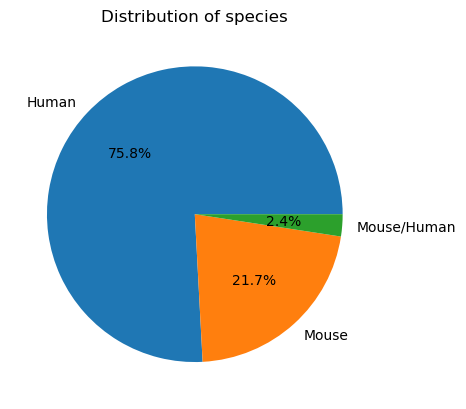

In [5]:
plt.title("Distribution of species")

structures_summary.value_counts("species").plot.pie(autopct="%1.1f%%")
plt.ylabel("")

plt.show()

## TCRs

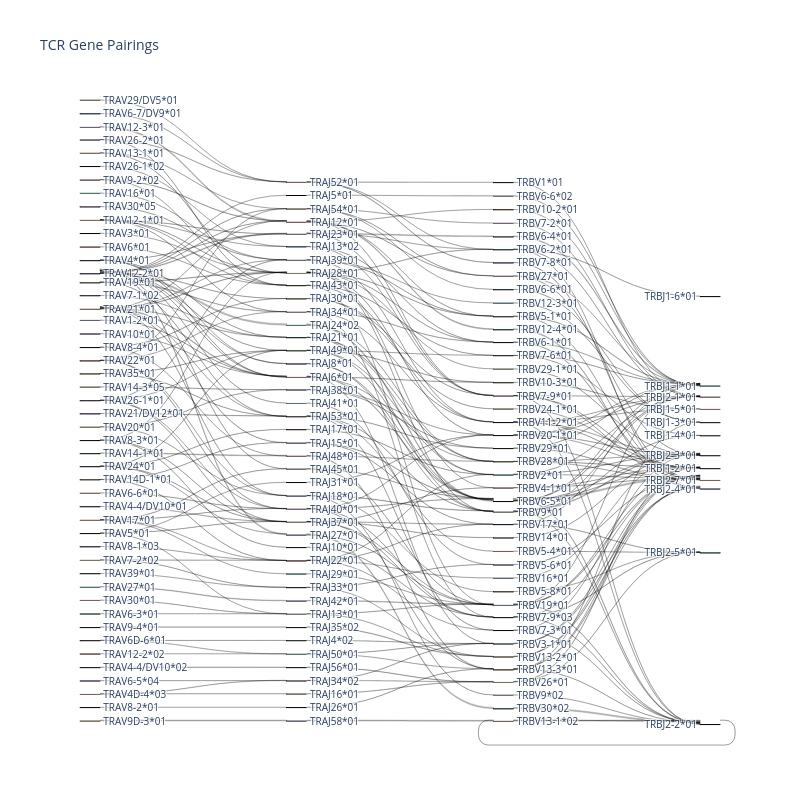

In [6]:
tcr_genes = structures_summary.filter(regex="[vj]_(alpha)|(beta)_gene")
gene_columns = tcr_genes.columns.tolist()

pairs = []
for i in range(len(gene_columns) - 1):
    flow = (
        tcr_genes.groupby([gene_columns[i], gene_columns[i + 1]])
        .size()
        .reset_index(name="count")
    )
    pairs.append(flow)

all_genes = pd.concat(
    [df[[gene_columns[i], gene_columns[i + 1]]] for i, df in enumerate(pairs)]
)
unique_genes = pd.unique(all_genes.values.ravel())
gene_to_index = {gene: i for i, gene in enumerate(unique_genes)}

sources, targets, values = [], [], []
for i, df in enumerate(pairs):
    for _, row in df.iterrows():
        sources.append(gene_to_index[row[gene_columns[i]]])
        targets.append(gene_to_index[row[gene_columns[i + 1]]])
        values.append(row["count"])

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=list(unique_genes),
            ),
            link=dict(source=sources, target=targets, value=values),
        )
    ]
)

fig.update_layout(title_text="TCR Gene Pairings", height=800, width=800, font_size=10)
fig.show(renderer='png')

In [7]:
cdr_sequences = structures_summary.filter(regex="^cdr[ab][1-3]_sequence$")
cdr_sequences = cdr_sequences.melt(
    value_vars=cdr_sequences.columns, value_name="sequence", var_name="cdr_type"
)

cdr_sequences[["chain_type", "cdr"]] = (
    cdr_sequences["cdr_type"]
    .map(
        lambda cdr_type: tuple(cdr_type.replace("cdr", "").replace("_sequence", "")),
    )
    .apply(pd.Series)
)

cdr_sequences["chain_type"] = cdr_sequences["chain_type"].map(
    {"a": "alpha_chain", "b": "beta_chain"}
)
cdr_sequences["cdr"] = cdr_sequences["cdr"].apply(int)

cdr_sequences["length"] = cdr_sequences["sequence"].str.len()

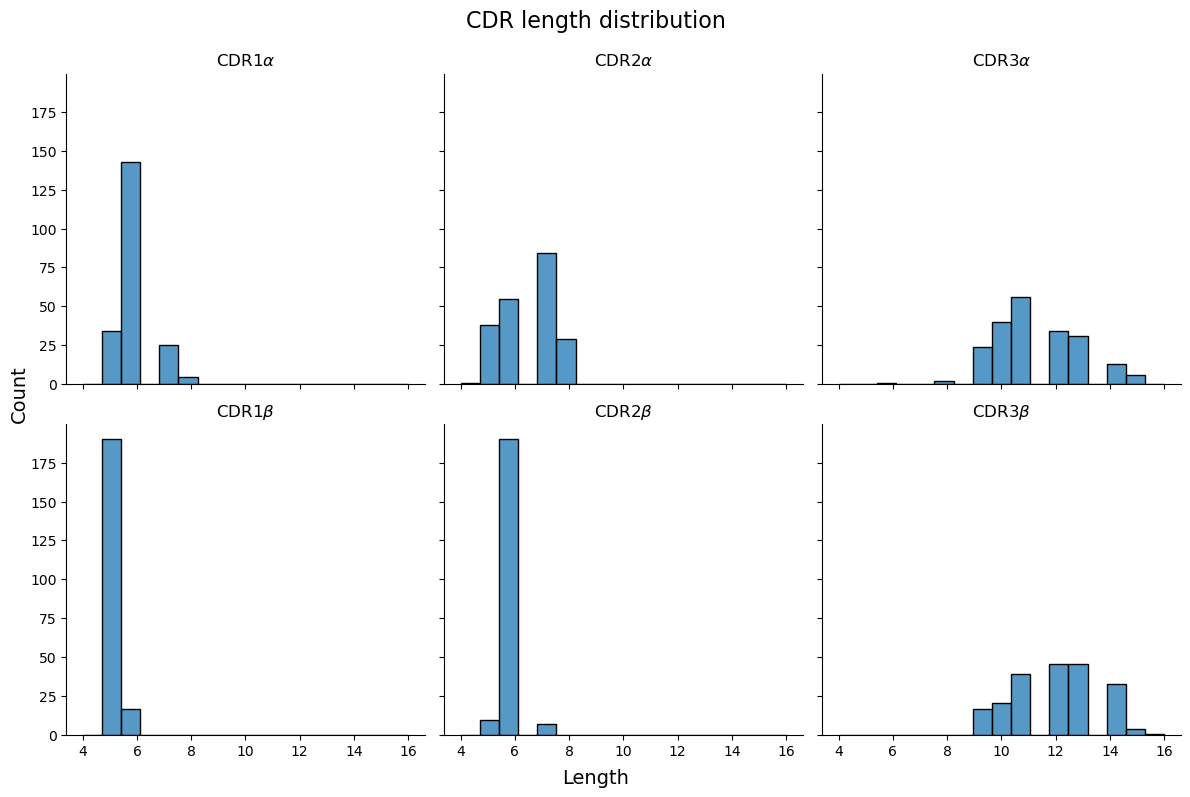

In [8]:
grid = sns.displot(
    cdr_sequences.sort_values(["chain_type", "cdr"]),
    x="length",
    row="chain_type",
    col="cdr",
    height=4,
)

grid.figure.suptitle("CDR length distribution", fontsize=16)
grid.figure.subplots_adjust(top=0.9)

grid.set_axis_labels("", "")
grid.figure.text(0.5, 0.02, "Length", ha="center", va="center", fontsize=14)
grid.figure.text(
    0.02, 0.5, "Count", ha="center", va="center", rotation="vertical", fontsize=14
)

grid.set_titles("")
for (chain_type, cdr), ax in grid.axes_dict.items():
    custom_title = f"CDR{cdr}" + (
        r"$\alpha$" if chain_type == "alpha_chain" else r"$\beta$"
    )
    ax.set_title(custom_title, fontsize=12)

plt.show()

## pMHCs

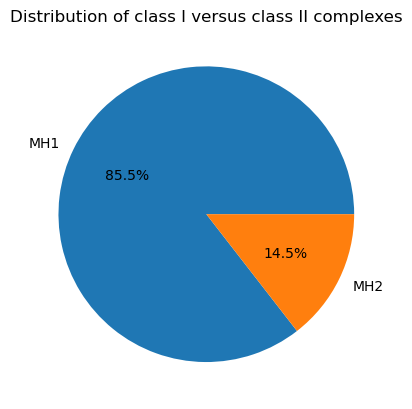

In [9]:
plt.title("Distribution of class I versus class II complexes")

structures_summary.value_counts("mhc_type").plot.pie(autopct="%1.1f%%")
plt.ylabel("")

plt.show()

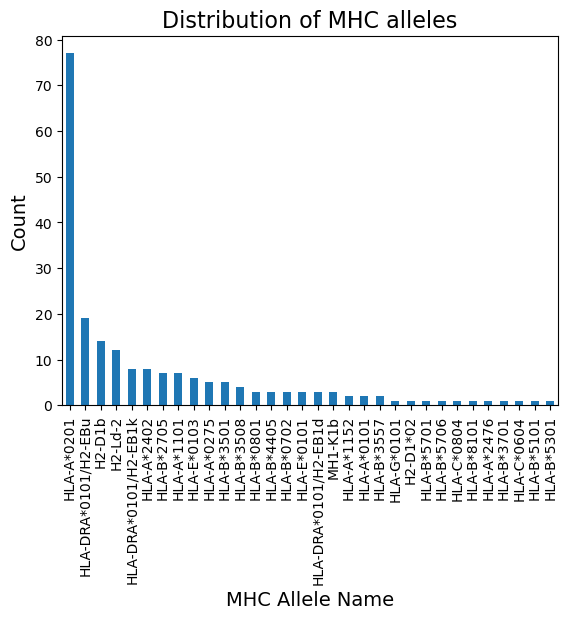

In [10]:
(
    structures_summary[["mhc1_gene", "mhc2_gene"]]
    .fillna("")
    .replace("('human', 'B2M*02')", "")
    .apply(lambda row: "/".join([entry for entry in row if entry]), axis=1)
    .value_counts()
    .plot.bar()
)

plt.title("Distribution of MHC alleles", fontsize=16)

plt.ylabel("Count", fontsize=14)
plt.xlabel("MHC Allele Name", fontsize=14)

plt.show()

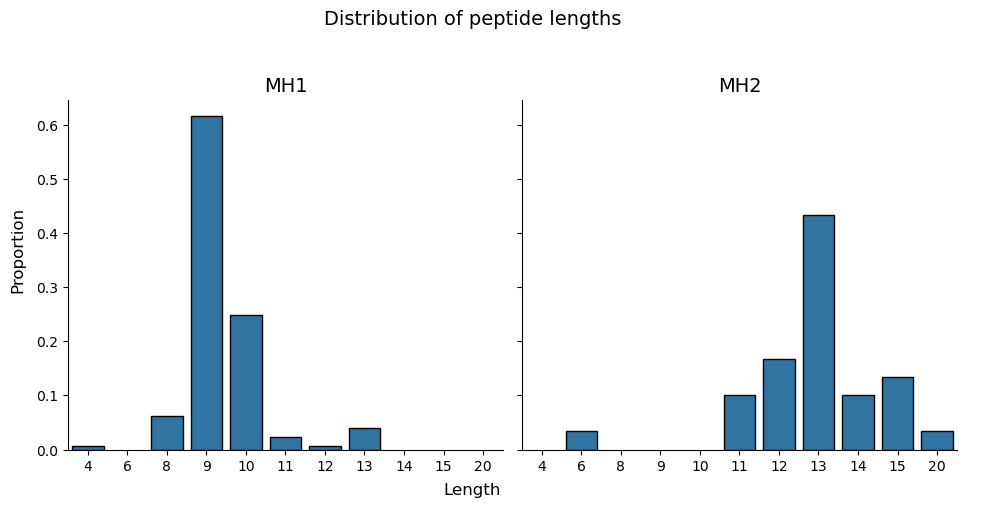

In [11]:
structures_summary["antigen_length"] = structures_summary["antigen_sequence"].str.len()

grid = sns.catplot(
    structures_summary.groupby("mhc_type")["antigen_length"]
    .value_counts(normalize=True)
    .reset_index(),
    x="antigen_length",
    y="proportion",
    col="mhc_type",
    kind="bar",
    edgecolor="black",
    linewidth=1.0,
)
grid.figure.suptitle("Distribution of peptide lengths", fontsize=14)
grid.figure.subplots_adjust(top=0.8, bottom=0.1, left=0.1)

grid.set_titles(col_template="{col_name}", size=14)

grid.set_axis_labels("", "")
grid.figure.text(0.5, 0.02, "Length", ha="center", va="center", fontsize=12)
grid.figure.text(
    0.05, 0.5, "Proportion", ha="center", va="center", rotation="vertical", fontsize=12
)


plt.show()

## TCR:pMHC complex geometry

The expected distribution are based on the values reported in "[STCRpy: a software suite for T cell receptor structure parsing, interaction profiling and machine learning dataset preparation](https://www.biorxiv.org/content/10.1101/2025.04.25.650667v1)".

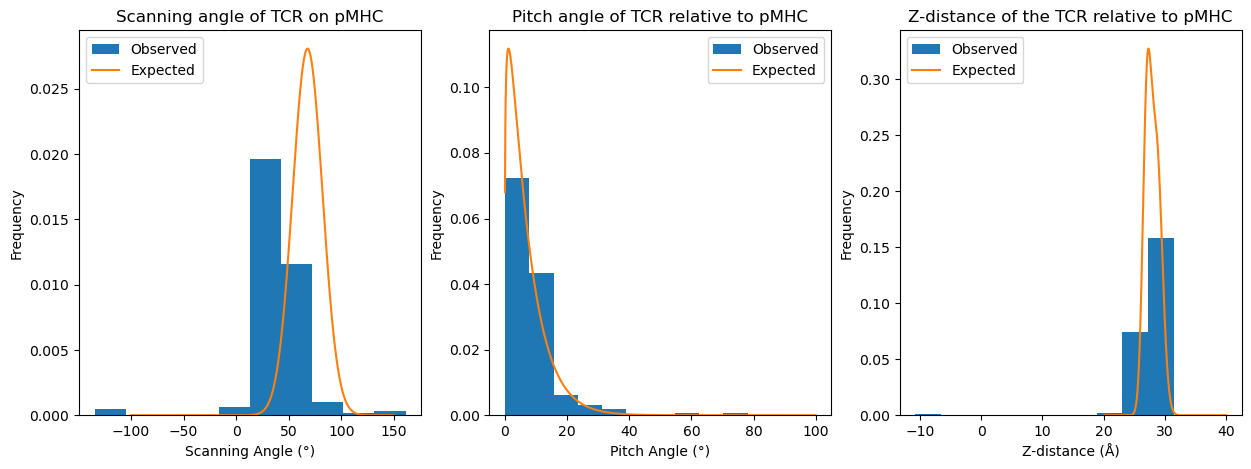

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

structures_summary["scanning_angle"].plot.hist(density=True, label="Observed", ax=ax1)

x = np.linspace(-100, 150, 1000)
scanning_angle = stats.norm.pdf(x, 67.9, np.sqrt(202.1))

ax1.plot(x, scanning_angle, label="Expected")

ax1.legend()
ax1.set_title("Scanning angle of TCR on pMHC")
ax1.set_xlabel("Scanning Angle (°)")

structures_summary["pitch_angle"].plot.hist(density=True, label="Observed", ax=ax2)

x = np.linspace(0.0365, 100, 1000)
pitch_angle = stats.gamma.pdf(x, a=1.20, scale=5.78)

ax2.plot(x, pitch_angle, label="Expected")

ax2.legend()
ax2.set_title("Pitch angle of TCR relative to pMHC")
ax2.set_xlabel("Pitch Angle (°)")

structures_summary["z_distance"].plot.hist(density=True, label="Observed", ax=ax3)

def z_distance(x: float | np.ndarray) -> float | np.ndarray:
    means = [27.05, 28.62]
    variances = [0.468, 0.908]
    weights = [0.434, 0.566]

    pdfs = [
        w * stats.norm.pdf(x, loc=mu, scale=np.sqrt(var))
        for w, mu, var in zip(weights, means, variances, strict=True)
    ]

    return np.sum(pdfs, axis=0)

x = np.linspace(20, 40, 1000)
ax3.plot(x, z_distance(x), label="Expected")

ax3.legend()
ax3.set_title("Z-distance of the TCR relative to pMHC")
ax3.set_xlabel("Z-distance (Å)")

plt.show()

In [13]:
interactions = []
for path in glob.glob("data/interim/structures/*_interactions.csv"):
    name = os.path.basename(path).replace("_interactions.csv", "")

    df = pd.read_csv(path)
    df["name"] = name

    interactions.append(df)

interactions = pd.concat(interactions)

In [14]:
tcr_peptide_interactions = interactions[
    ((interactions["protein_chain"] == "D") | (interactions["protein_chain"] == "E"))
    & interactions["protein_residue"]
    .str.title()
    .isin(IUPACData.protein_letters_3to1.keys())
    & interactions["ligand_residue"]
    .str.title()
    .isin(IUPACData.protein_letters_3to1.keys())
]

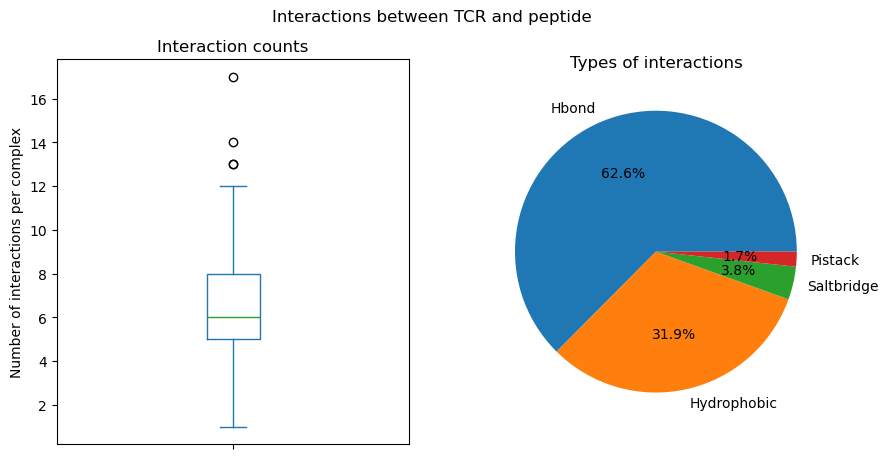

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Interactions between TCR and peptide")

tcr_peptide_interactions.groupby("name").size().plot.box(ax=ax1)

ax1.set_title("Interaction counts")
ax1.set_ylabel("Number of interactions per complex")

tcr_peptide_interactions["type"].str.title().value_counts().plot.pie(
    autopct="%1.1f%%", ax=ax2
)

ax2.set_title("Types of interactions")
ax2.set_ylabel("")

plt.show()